# Hands On ML Chapter 3 - Classification

In [1]:
from sklearn.datasets import fetch_mldata
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## Get the MNIST dataset

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X,y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

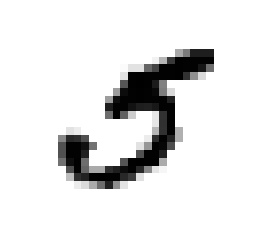

5.0

In [4]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
y[36000]

## Train/Test

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## SGDClassifier - example of binary classifier

Lets predict if given number are 5s or not.

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([False, False,  True, ..., False, False, False], dtype=bool)

In [8]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [9]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96195,  0.9595 ,  0.90695])

Lets create Never5Classifier, its method "predict" returns only 0s.

In [10]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)



Cross_val_score returns over 90% accuracy. Why? Because only 10% of the set are 5s. So if we always guess that image is not 5, we are right 90% of the time.

In [11]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9081 ,  0.9076 ,  0.91325])

### Confusion Matrix, Precision, Recall, Threshold

Better way to evaluate the performance of classifier is to use Confusion Matrix.

cross_val_predict works like cross_val_score but returns predictions not evaluations (K-Fold cross-validation). It makes clean predictions. What does it mean? It divides train_set into 3 groups, it takes two of them to make a model and the last one to make predictions on it.

In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Confusion Matrix returns an array. It is divided into 4 parts:

                        Predicted
                    Negative | Positive|
    Actual Negative|8,3,9    | 6       |
           Positive|5,5      |5,5,5    |

True negatives, false positives,

False negatives, true positives.

In [13]:
confusion_matrix(y_train_5, y_train_pred)

array([[52223,  2356],
       [ 1076,  4345]])

precision = TP/(TP+FP)

In [14]:
precision_score(y_train_5, y_train_pred)

0.64841068497239218

recall = TP/(TP+FN)

In [15]:
recall_score(y_train_5, y_train_pred)

0.80151263604501011

Combine precision and recall to one metric called F1

In [16]:
f1_score(y_train_5, y_train_pred)

0.71687840290381122

When precision increases, recall decreases and vice versa. You can manipulate threshold to choose either higher precision or higher recall. 

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 40153.4876909])

In that case threshold is 0 and digit is predicted as 5. It is good prediction.

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In that case we increased threshold. With increasing threshold we decreased recall. Classifiers predicted this image as not 5.

In [19]:
threshold = 25000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Lets plot precision and recall to find threshold which fullfill our expectations

In [21]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

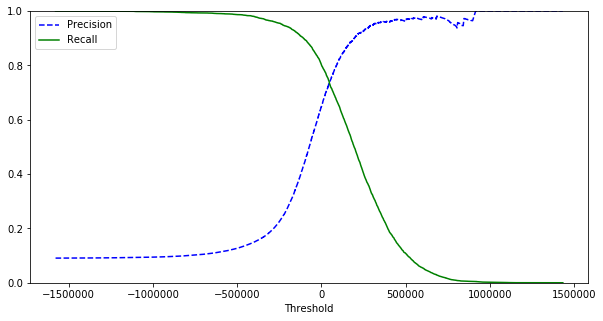

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

We can see that curve starts to goes faster down when precision is equal to 0.8

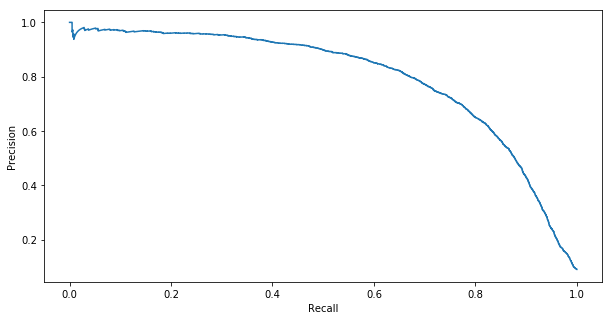

In [23]:
plt.figure(figsize=(10,5))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")

Find threshold on which precision is more or less 90%

In [24]:
y_train_pred_90 = (y_scores > 10000)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.6706398996235885

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.78878435712968087

ROC Curve

In [27]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Closer the curve gets to the line, lower is quality of classifier.

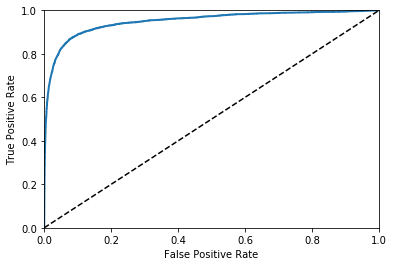

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [29]:
roc_auc_score(y_train_5, y_scores)

0.94972029175555173

Random Forest Classifier to compare results

In [30]:
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [31]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

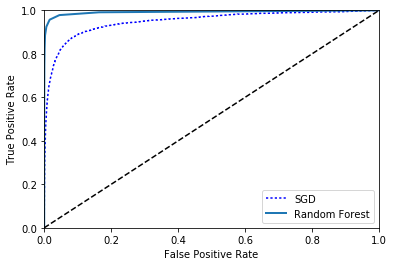

In [32]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [33]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

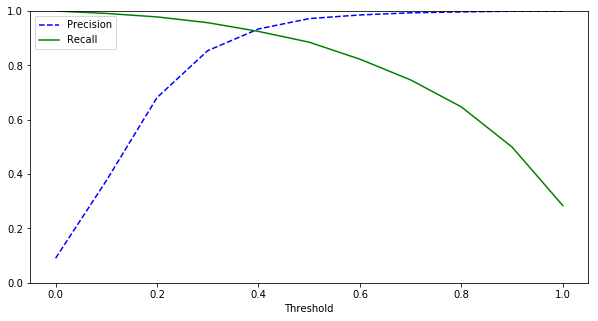

In [34]:
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)

In [35]:
y_train_forest_pred_90 = (y_scores_forest > 0.5)

Scores are better for Random Forest Classifier

In [36]:
precision_score(y_train_5, y_train_forest_pred_90)

0.98541758727353068

In [37]:
recall_score(y_train_5, y_train_forest_pred_90)

0.82272643423722558

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.99205494447023423

## Multiclass Classification

Same as above but instead of two classes we have more here.

In [39]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [40]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-148901.0932911 , -365872.12795016, -353965.97858416,
        -235466.39398303, -449441.10251108,   40153.4876909 ,
        -643792.87686919, -248273.3130597 , -710876.78814748,
        -609125.78471911]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
sgd_clf.classes_[5]

5.0

In [43]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [44]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.7,  0. ,  0.1,  0. ,  0. ]])

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.8709758 ,  0.86414321,  0.88248237])

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91071786,  0.91129556,  0.90908636])

## Error Analysis

In [57]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5728,    2,   26,    9,    8,   48,   46,   10,   40,    6],
       [   1, 6471,   44,   28,    6,   36,    7,    9,  128,   12],
       [  52,   34, 5348,   90,   73,   23,   99,   58,  162,   19],
       [  43,   39,  130, 5354,    2,  234,   34,   59,  142,   94],
       [  16,   25,   39,   12, 5373,    8,   53,   32,   86,  198],
       [  67,   42,   34,  178,   74, 4620,  105,   29,  182,   90],
       [  32,   26,   41,    2,   41,  101, 5624,    5,   46,    0],
       [  23,   21,   66,   30,   60,    9,    7, 5788,   17,  244],
       [  53,  151,   73,  152,   13,  159,   49,   25, 5036,  140],
       [  41,   35,   27,   89,  150,   40,    3,  205,   79, 5280]])

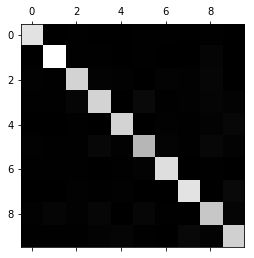

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

Normalize and fill diagonal with zeros for better view.
Lighter points represents higher value. Higher value means more incorrent predictions. For example a lot of 3 were predicted as 5 (third row, fifth column).

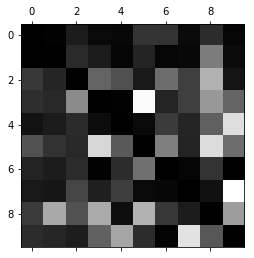

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

## Multilabel Classification

Multilabel means that we want to classify sample in multi ways. Below we have example: we want to predict if sample is higher or equal to 7 and if it is even number (each label is binary).

In [58]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [52]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [53]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
#f1_score(y_train, y_train_knn_pred, average="macro")

## Multioutput Classification

Here we also classify sample in multi ways but labels are also multiclass.

In [54]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [55]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5000]])

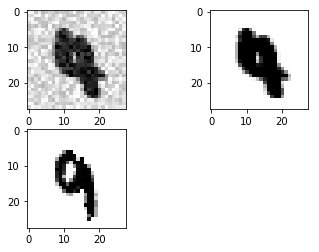

In [56]:
plt.subplot(221); plt.imshow(X_test_mod[5000].reshape(28,28), cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.subplot(222); plt.imshow(y_test_mod[5000].reshape(28,28), cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.subplot(223); plt.imshow(clean_digit.reshape(28,28), cmap = matplotlib.cm.binary, interpolation = "nearest")